In [1]:
import polars as pl

from nebula.base import Transformer
from nebula.transformers import *
from nebula.storage import nebula_storage as ns
from nebula.pipelines.pipeline import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline

%load_ext autoreload
%autoreload 2

In [2]:
df_input = pl.DataFrame({
        "idx": list(range(13)),
        "c1": ["a", "a", "a", "a", "a", "", "", None, " ", "", "a", "a", None],
        "c2": ["b", "b", "b", "b", "b", "", "", None, None, None, None, "", "b"],
    })

pipe = TransformerPipeline(
        [AddLiterals(data=[{"value": "matched", "alias": "c1"}])],
        apply_to_rows={
            "input_col": "idx",
            "operator": "gt",
            "value": 5,
        },
        otherwise=AddLiterals(data=[{"value": "not_matched", "alias": "c1"}]),
    )

pipe.show(add_params=True)

*** Pipeline *** (2 transformations)
------ APPLY TO ROWS (idx gt 5) ------
  - input_col: idx
  - operator: gt
  - value: 5
>> Apply To rows (1 transformation):
     - AddLiterals -> PARAMS: data=[{'value': 'matched', 'alias': 'c1'}]
>> Otherwise (1 transformation)
     - AddLiterals -> PARAMS: data=[{'value': 'not_matched', 'alias': 'c1'}]
<<< Append DFs >>>


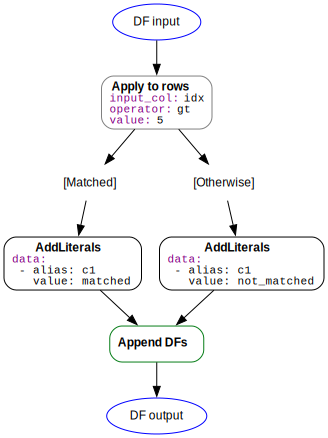

In [3]:
pipe.plot(add_params=True)

In [4]:
df_out = pipe.run(df_input, show_params=True)
df_out.sort("idx")

2025-12-25 05:03:40,066 | [INFO]: Starting pipeline 
2025-12-25 05:03:40,068 | [INFO]: Entering apply_to_rows 
2025-12-25 05:03:40,094 | [INFO]: Running 'AddLiterals' PARAMS: data=[{'value': 'matched', 'alias': 'c1'}] ... 
2025-12-25 05:03:40,105 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-25 05:03:40,107 | [INFO]: Running 'AddLiterals' PARAMS: data=[{'value': 'not_matched', 'alias': 'c1'}] ... 
2025-12-25 05:03:40,108 | [INFO]: Completed 'AddLiterals' in 0.0s 
2025-12-25 05:03:40,109 | [INFO]: Pipeline completed in 0.0s 


idx,c1,c2
i64,str,str
0,"""not_matched""","""b"""
1,"""not_matched""","""b"""
2,"""not_matched""","""b"""
3,"""not_matched""","""b"""
4,"""not_matched""","""b"""
…,…,…
8,"""matched""",null
9,"""matched""",null
10,"""matched""",null


In [ ]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "storage": "df_x"
      "end": "dead-end"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1
      - store: "df_fork"

  - transformer: Persist
  - transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** fork of the primary DF
- **Output:** dead-end

In [ ]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "end": "dead-end"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1
      - store: "df_fork"

  - pipeline:
      transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** fork of the primary DF
- **Output:** append

In [ ]:
yml_data = """
pipeline:
  - pipeline:
      - transformer: Distinct

  - branch:
      "end": "append"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "c1"
          value: "c"

  - transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** from storage
- **Output:** append

In [ ]:
yml_data = """
pipeline:
  - pipeline:
      - transformer: Distinct

  - branch:
      "storage": "df_x"
      "end": "append"
    pipeline:
      - transformer: WithColumn
        params:
          column_name: "c1"
          value: "c"

  - transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** fork of the primary DF
- **Output:** join

In [ ]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "end": "join"
      "on": "idx"
      "how": "inner"
    pipeline:
      - transformer: DropColumns
        params:
          columns: [ "c1", "c2" ]
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1

  - pipeline:
      transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()

- **Input:** from storage
- **Output:** join

In [ ]:
yml_data = """
pipeline:
  - transformer: Distinct

  - branch:
      "storage": "df_x"
      "end": "join"
      "on": "idx"
      "how": "inner"
    pipeline:
      - transformer: DropColumns
        params:
          columns: [ "c1", "c2" ]
      - transformer: WithColumn
        params:
          column_name: "new"
          value: -1

  - pipeline:
      transformer: Count
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)
pipe.plot_dag()